Dependencies:<br>
- Pls make sure u create a 'cGAN' folder in the same directory as this file to save weights
- pip/conda install any missing modules (especially tensorflow_addons)

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
from tensorflow import keras
from keras.layers import Reshape, Conv2DTranspose, PReLU
from keras.utils import to_categorical, plot_model
from keras.layers import Concatenate
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.image import resize
from scipy.linalg import sqrtm
import math
# from tqdm.notebook import tqdm
import tensorflow as tf
from IPython.display import clear_output, HTML
import glob
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential, Model
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from tensorflow_addons.layers import SpectralNormalization
from keras.layers import LeakyReLU, GlobalMaxPooling2D, GlobalAveragePooling2D

c:\Users\hazem\anaconda3\envs\gpu_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\hazem\anaconda3\envs\gpu_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
I

In [3]:
tf.version

<module 'tensorflow._api.v2.version' from 'C:\\Users\\hazem\\AppData\\Roaming\\Python\\Python310\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>

In [4]:
from keras.datasets.cifar10 import load_data

(X_train, y_train), (_, _) = load_data()

In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  # tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

X_train_aug = data_augmentation(X_train)
X_train = np.concatenate((X_train, X_train_aug), axis=0)

if X_train.shape[0] > 50000:
    y_train = np.concatenate((y_train, y_train), axis=0)

In [6]:
class_labels = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

NUM_CLASS = 10

y_train = to_categorical(y_train)
pre_processing_v1 = Normalization()
pre_processing_v1.adapt(X_train)
X_train = X_train.astype('float32')
X_train /= (255/2)
X_train -= 1

In [8]:
noise = 128

# function to create generator model
def create_improve_cGAN_generator(noise):

    # gaussian weights initialization
    weights_init = RandomNormal(mean=0, stddev=0.02)

    # latent noise vector z
    z = Input(shape=(noise,), name="Latent_Noise_Vector_z")

    # conditions y
    conditions = Input(shape=(10,), name='Conditions_y')

    # Generator network
    merged_layer = Concatenate()([z, conditions])

    # FC: 2x2x512
    generator = Dense(2*2*512, activation='relu')(merged_layer)
    generator = BatchNormalization(momentum=0.8)(generator)
    generator = PReLU()(generator)
    generator = Reshape((2, 2, 512))(generator)

    base_generator = Sequential([
        # Conv 1: 4x4x256
        SpectralNormalization(Conv2DTranspose(256, kernel_size=4, strides=2,
                                              padding='same', kernel_initializer=weights_init)),
        BatchNormalization(momentum=0.8),
        PReLU(),
        # Conv 2: 8x8x128
        SpectralNormalization(Conv2DTranspose(128, kernel_size=4, strides=2,
                                              padding='same', kernel_initializer=weights_init)),
        BatchNormalization(momentum=0.8),
        PReLU(),
        # Conv 3: 16x16x64
        SpectralNormalization(Conv2DTranspose(64, kernel_size=4, strides=2,
                                              padding='same', kernel_initializer=weights_init)),
        BatchNormalization(momentum=0.8),
        PReLU(),
    ], name='Base_Generator')
    generator = base_generator(generator)

    # Conv 4: 32x32x3
    generator = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same',
                                activation='tanh', name='Output_Layer')(generator)

    generator = Model(inputs=[z, conditions],
                      outputs=generator,  name='generator_cGAN')
    return generator

In [9]:
# function to create discriminator model
def create_improve_cGAN_discriminator(image_size):
    # input image
    img_input = Input(shape=(image_size), name='Image_Input')
    weights_init = RandomNormal(mean=0, stddev=0.02)

    # conditions y
    conditions = Input(shape=(10,), name='Conditions_y')

    base_discriminator = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Conv2D(128, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Conv2D(256, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Conv2D(512, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
    ], name='Base_Discriminator')
    discriminator = base_discriminator(img_input)

    discriminator = GlobalAveragePooling2D()(discriminator)

    # Concatenate - combine with conditions y
    merged_layer = Concatenate()([discriminator, conditions])
    discriminator = Dense(512, activation='relu')(merged_layer)

    # Output
    discriminator = Dense(1,
                          name='Output_Layer')(discriminator)

    discriminator = Model(inputs=[img_input, conditions],
                          outputs=discriminator, name='discriminator_cGAN')
    return discriminator

In [10]:
class NewcGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=20, noise=128, patience=10, vmin=0, vmax=1):
        self.num_img = num_img
        self.noise = noise
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax
        self.latent_noise_vector = tf.random.normal(
            shape=(self.num_img, self.noise))
        self.conditions = to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                          0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator.predict(
            [self.latent_noise_vector, self.conditions])
        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)
        row_size = int(np.ceil(self.num_img/5))
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(row_size, 5, i+1)
            ax.imshow(generated_images[i])
            ax.set_title(class_labels[i % 10])
            ax.axis('off')
        plt.show()

    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                name = 'cGAN/generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')


In [11]:
callbacks = [
    NewcGANMonitor(num_img=20, noise=128, patience=5, vmin=-1, vmax=1),
]


In [12]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, noise):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise = noise
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(
            name="discriminator_loss")
        # self.d_xy_tracker = tf.keras.metrics.Mean(name='Mean D(x|y)')
        # self.d_g_zy_tracker = tf.keras.metrics.Mean(name='Mean D(G(z|y))')
        # self.kl = tf.keras.metrics.KLDivergence()

    def compile(self, d_optimizer, g_optimizer, gloss_fn, dloss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.gloss_fn = gloss_fn
        self.dloss_fn = dloss_fn

    def train_step(self, data):
        ### TRAINING DISCRIMINATOR ###
        # Unpack the data.
        real_images, condition = data

        # Sample for latent noise vector z
        batch_size = tf.shape(real_images)[0]
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.noise))

        # Maps the noise latent vector and labels to generate fake images.
        generated_images = self.generator([latent_noise_vector, condition])

        # Combine with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_condition = tf.concat([condition, condition], axis=0)

        # Discrimination
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            first_predictions = self.discriminator(
                [combined_images, combined_condition])
            d_loss = self.dloss_fn(labels, first_predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # # Computing D(x|y)
        # d_xy = tf.math.reduce_mean(first_predictions)

        ### TRAINING GENRATOR ###
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.noise))

        # Assemble labels that say "all real images".
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator([latent_noise_vector, condition])
            second_predictions = self.discriminator([fake_images, condition])
            g_loss = self.gloss_fn(misleading_labels, second_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        # # Computing D(G(z|y))
        # d_g_zy = tf.math.reduce_mean(second_predictions)

        # Monitor loss and metrics.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)

        return {
            "d_loss": self.disc_loss_tracker.result(),
            "g_loss": self.gen_loss_tracker.result(),

        }

In [13]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # we compare the prediction on real images to 0.8 instead of 1
    real_loss = loss_function(tf.ones_like(real_output)*0.8, real_output)
    # real_loss will quantify our loss to distinguish the real images
    
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    # fake_loss will quantify our loss to distinguish the fake images (generated)
    
    # Two-sided label smoothing : 
    # Uncomment the next line and comment the last one if you want to try it
#     fake_loss = loss_function(tf.ones_like(fake_output)*0.1, fake_output)
    
    # Real image = 1, Fake image = 0 (array of ones and zeros)
    total_loss = real_loss + fake_loss
    return total_loss

# def generator_loss(fake_output):
#     # We want the false images to be seen as real images (1)
#     return loss_function(tf.ones_like(fake_output), fake_output)

c:\Users\hazem\anaconda3\envs\gpu_env\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(



1/1 [==============================] - 0s 290ms/step


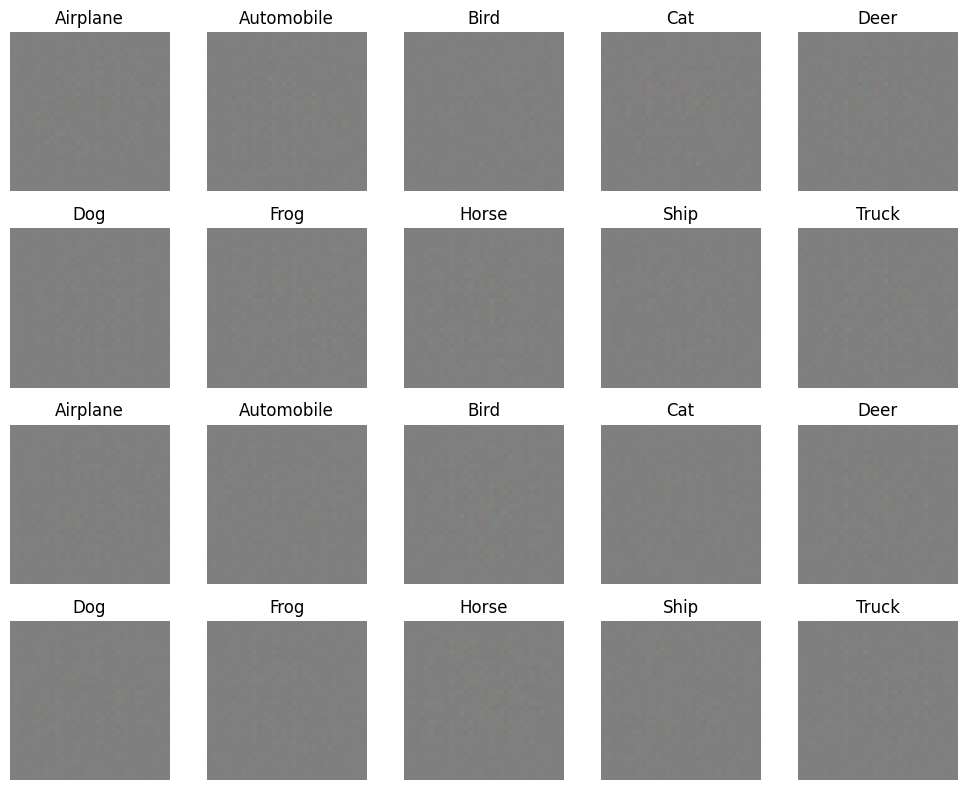

Generator Checkpoint - cGAN/generator-epoch-0.h5
Epoch 1/100
1563/1563 [==============================] - 249s 157ms/step - d_loss: 0.6212 - g_loss: 11.2098
Epoch 2/100
1563/1563 [==============================] - 240s 153ms/step - d_loss: 0.6032 - g_loss: 15.6288
Epoch 3/100
1563/1563 [==============================] - 230s 147ms/step - d_loss: 0.6032 - g_loss: 17.0307
Epoch 4/100
1563/1563 [==============================] - 250s 160ms/step - d_loss: 0.6032 - g_loss: 18.0620
Epoch 5/100
1/1 [==============================] - 0s 22ms/step


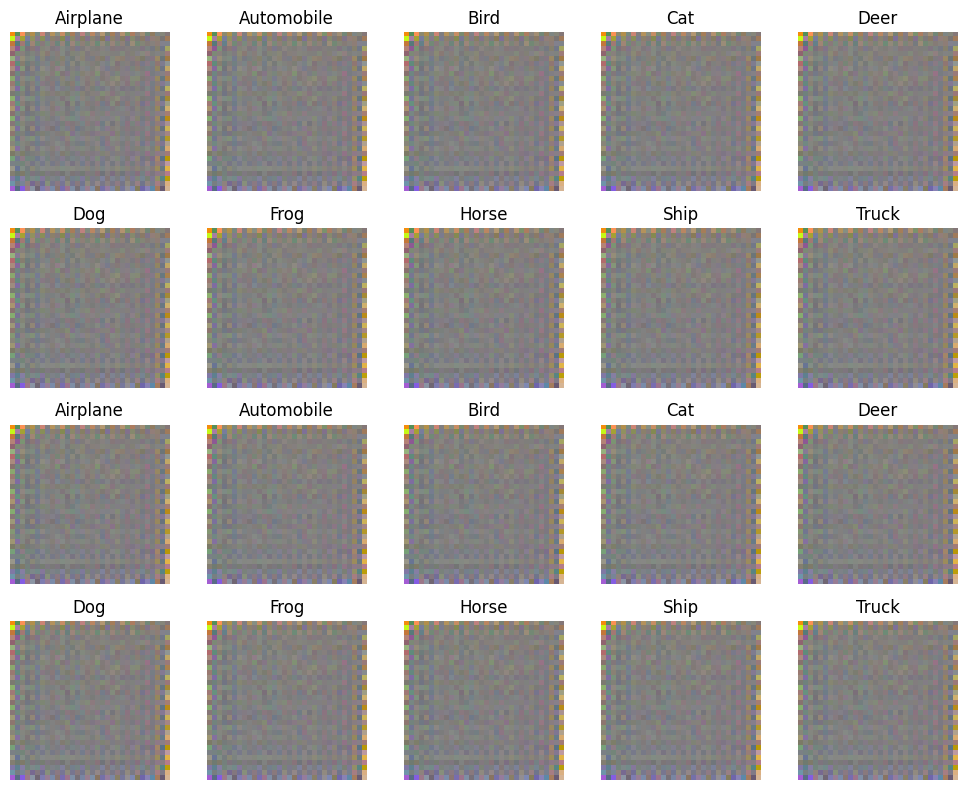

Generator Checkpoint - cGAN/generator-epoch-5.h5
Epoch 6/100
1563/1563 [==============================] - 266s 170ms/step - d_loss: 0.6032 - g_loss: 19.7189
Epoch 7/100
1563/1563 [==============================] - 253s 162ms/step - d_loss: 0.6032 - g_loss: 20.4356
Epoch 8/100
1563/1563 [==============================] - 276s 176ms/step - d_loss: 0.6032 - g_loss: 21.1032
Epoch 9/100
1563/1563 [==============================] - 260s 166ms/step - d_loss: 0.6032 - g_loss: 21.7368
Epoch 10/100
1/1 [==============================] - 0s 28ms/step


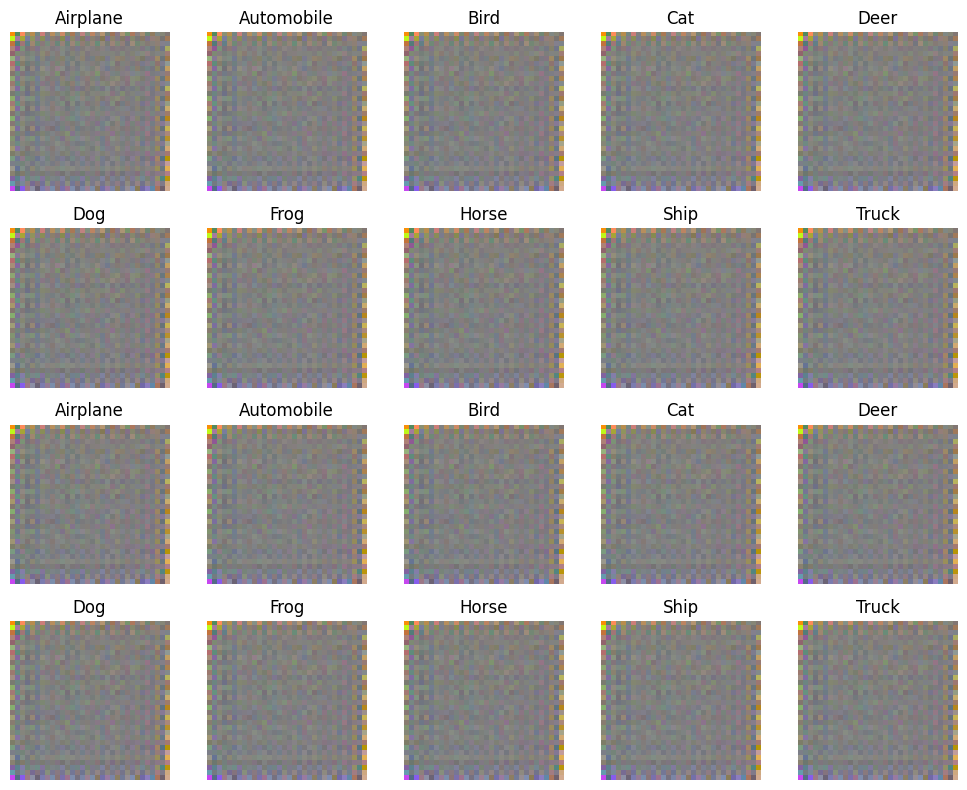

Generator Checkpoint - cGAN/generator-epoch-10.h5
Epoch 11/100
1563/1563 [==============================] - 262s 167ms/step - d_loss: 0.6032 - g_loss: 22.9745
Epoch 12/100
1563/1563 [==============================] - 260s 166ms/step - d_loss: 0.6032 - g_loss: 23.6083
Epoch 13/100
1563/1563 [==============================] - 257s 164ms/step - d_loss: 0.6032 - g_loss: 24.2524
Epoch 14/100
1563/1563 [==============================] - 254s 163ms/step - d_loss: 0.6032 - g_loss: 24.8931
Epoch 15/100
1/1 [==============================] - 0s 25ms/step


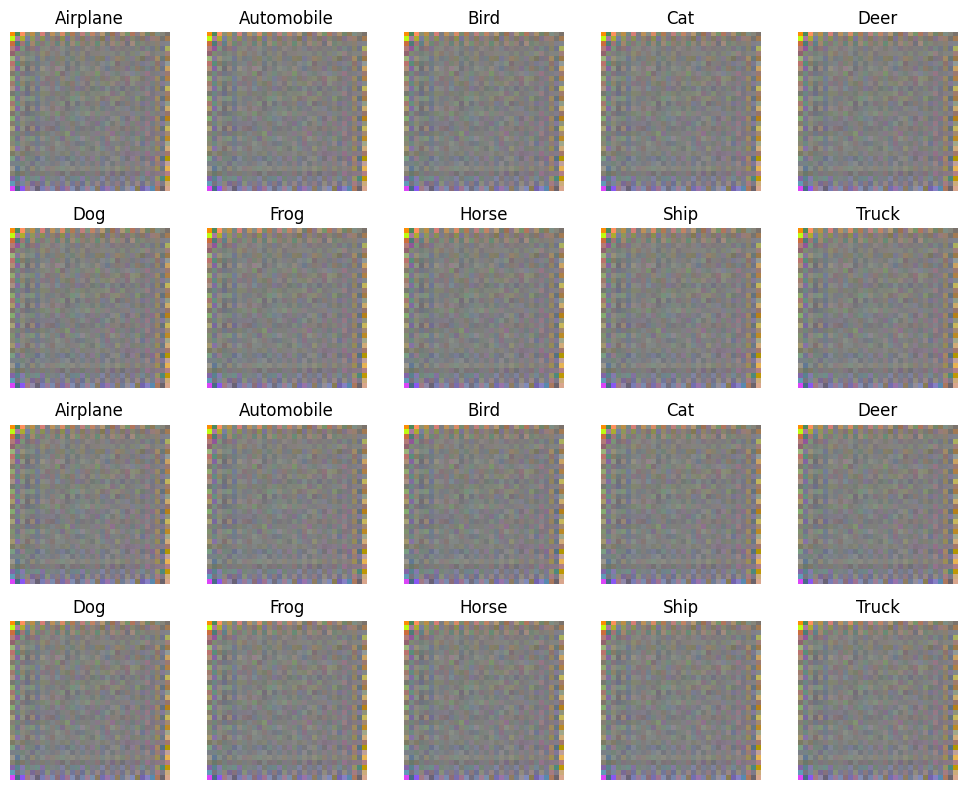

Generator Checkpoint - cGAN/generator-epoch-15.h5
Epoch 16/100
1563/1563 [==============================] - 257s 164ms/step - d_loss: 0.6032 - g_loss: 26.0712
Epoch 17/100
1563/1563 [==============================] - 258s 165ms/step - d_loss: 0.6032 - g_loss: 26.5593
Epoch 18/100
1563/1563 [==============================] - 265s 169ms/step - d_loss: 0.6032 - g_loss: 26.9641
Epoch 19/100
1563/1563 [==============================] - 266s 170ms/step - d_loss: 0.6032 - g_loss: 27.2916
Epoch 20/100
1/1 [==============================] - 0s 25ms/step


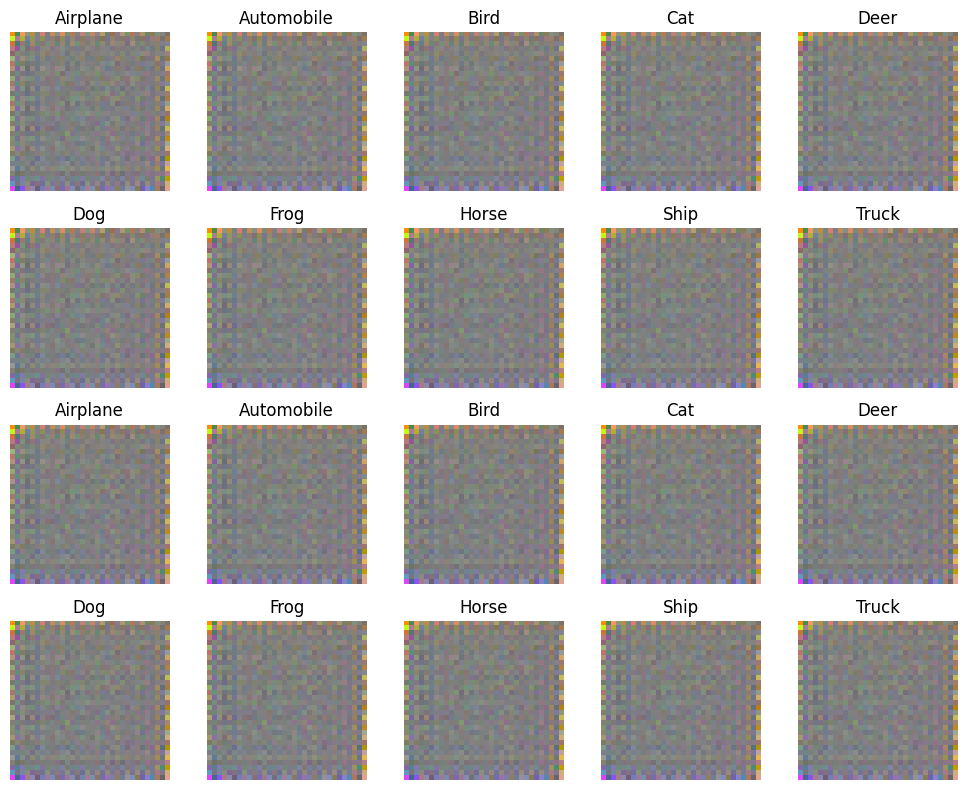

Generator Checkpoint - cGAN/generator-epoch-20.h5
Epoch 21/100
1563/1563 [==============================] - 266s 170ms/step - d_loss: 0.6032 - g_loss: 27.7721
Epoch 22/100
1563/1563 [==============================] - 262s 167ms/step - d_loss: 0.6032 - g_loss: 27.9528
Epoch 23/100
1563/1563 [==============================] - 265s 170ms/step - d_loss: 0.6032 - g_loss: 28.1071
Epoch 24/100
1563/1563 [==============================] - 268s 171ms/step - d_loss: 0.6032 - g_loss: 28.2412
Epoch 25/100
1/1 [==============================] - 0s 28ms/step


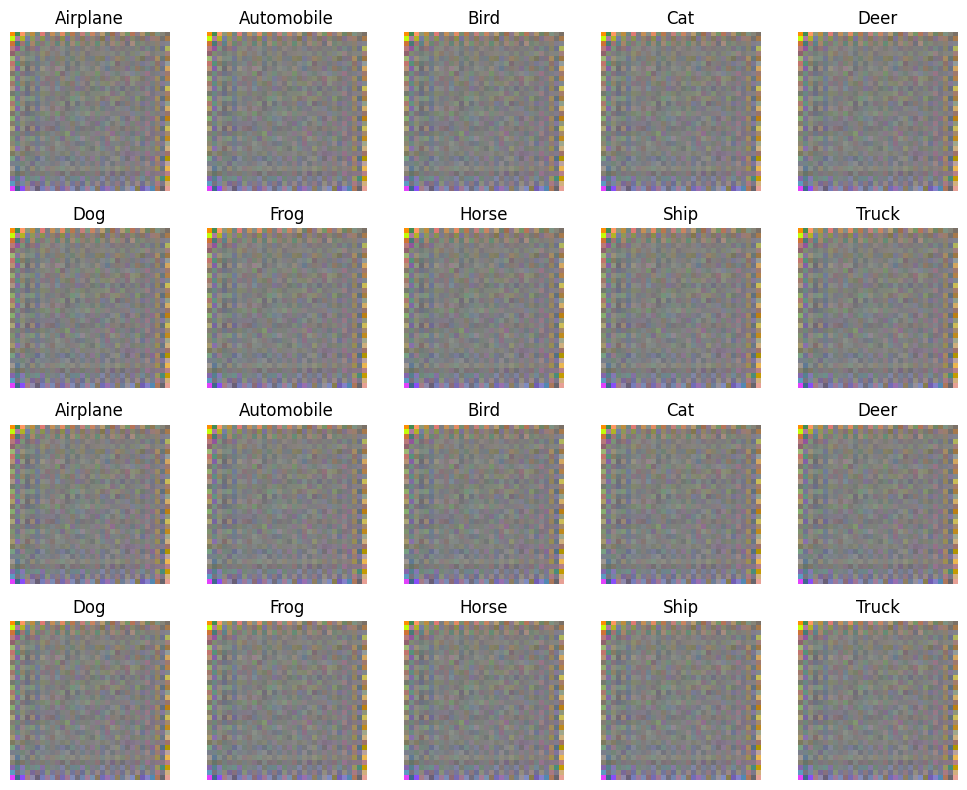

Generator Checkpoint - cGAN/generator-epoch-25.h5
Epoch 26/100
1563/1563 [==============================] - 266s 170ms/step - d_loss: 0.6032 - g_loss: 28.4654
Epoch 27/100
1563/1563 [==============================] - 252s 161ms/step - d_loss: 0.6032 - g_loss: 28.5611
Epoch 28/100
1563/1563 [==============================] - 248s 159ms/step - d_loss: 0.6032 - g_loss: 28.6485
Epoch 29/100
1563/1563 [==============================] - 246s 158ms/step - d_loss: 0.6032 - g_loss: 28.7288
Epoch 30/100
1/1 [==============================] - 0s 24ms/step


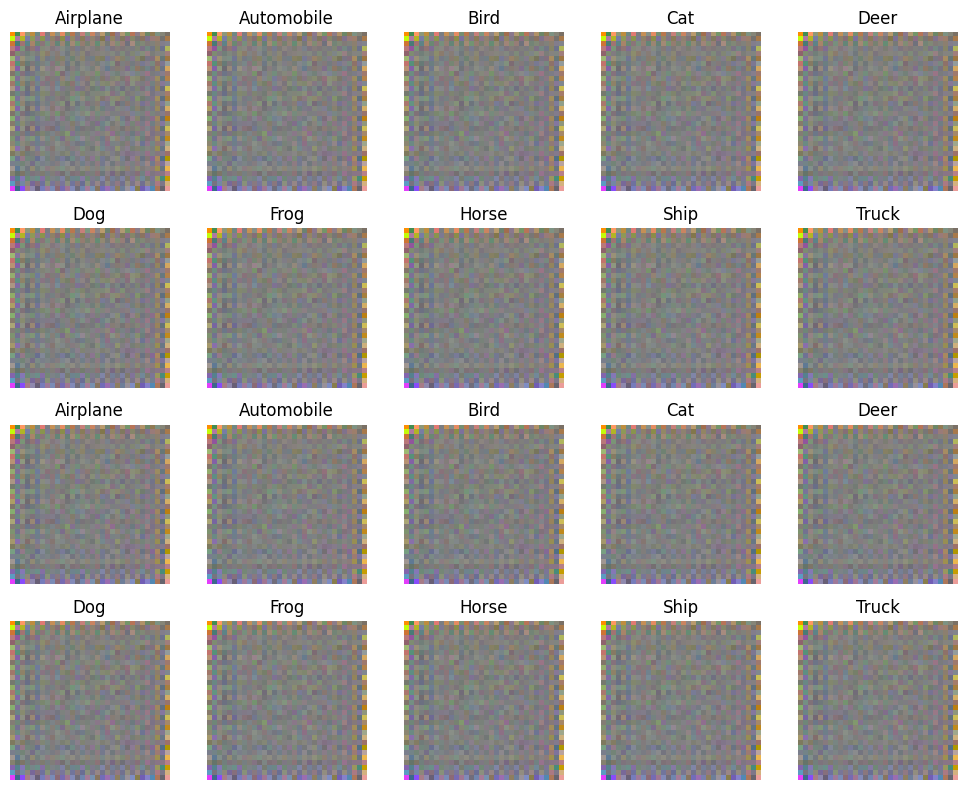

Generator Checkpoint - cGAN/generator-epoch-30.h5
Epoch 31/100
1563/1563 [==============================] - 248s 159ms/step - d_loss: 0.6032 - g_loss: 28.8725
Epoch 32/100
1563/1563 [==============================] - 249s 160ms/step - d_loss: 0.6032 - g_loss: 28.9371
Epoch 33/100
1563/1563 [==============================] - 250s 160ms/step - d_loss: 0.6032 - g_loss: 28.9979
Epoch 34/100
1563/1563 [==============================] - 244s 156ms/step - d_loss: 0.6032 - g_loss: 29.0552
Epoch 35/100
1/1 [==============================] - 0s 22ms/step


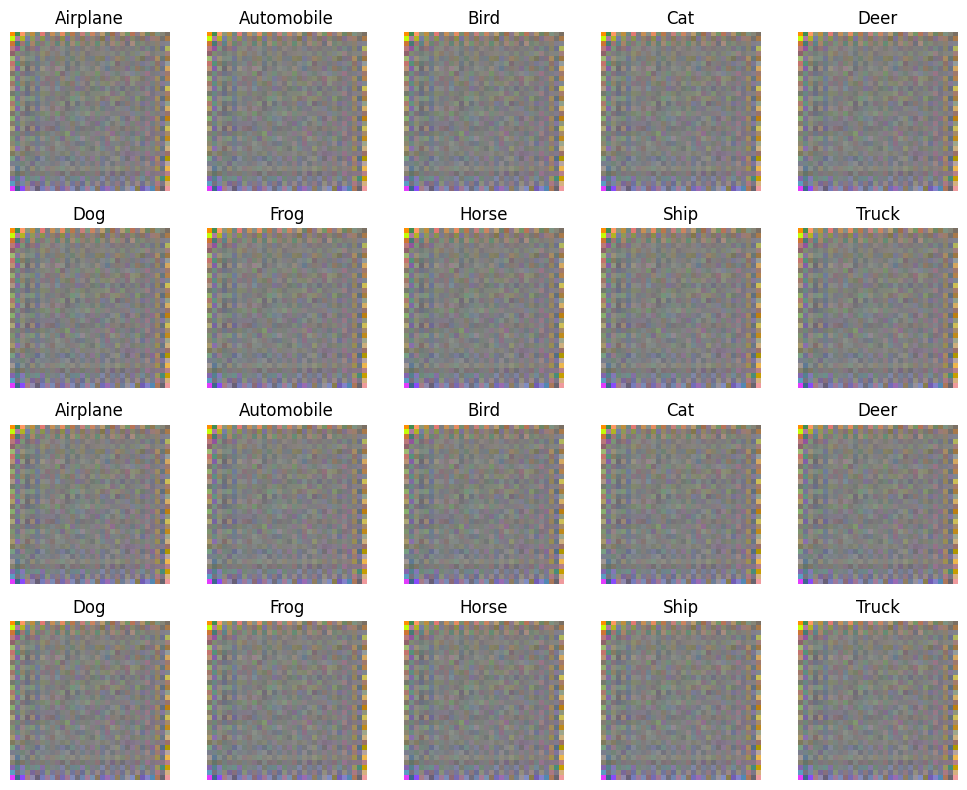

Generator Checkpoint - cGAN/generator-epoch-35.h5
Epoch 36/100
1563/1563 [==============================] - 234s 150ms/step - d_loss: 0.6032 - g_loss: 29.1608
Epoch 37/100
1563/1563 [==============================] - 235s 151ms/step - d_loss: 0.6032 - g_loss: 29.2097
Epoch 38/100
1563/1563 [==============================] - 236s 151ms/step - d_loss: 0.6032 - g_loss: 29.2564
Epoch 39/100
1563/1563 [==============================] - 237s 152ms/step - d_loss: 0.6032 - g_loss: 29.3008
Epoch 40/100
1/1 [==============================] - 0s 32ms/step


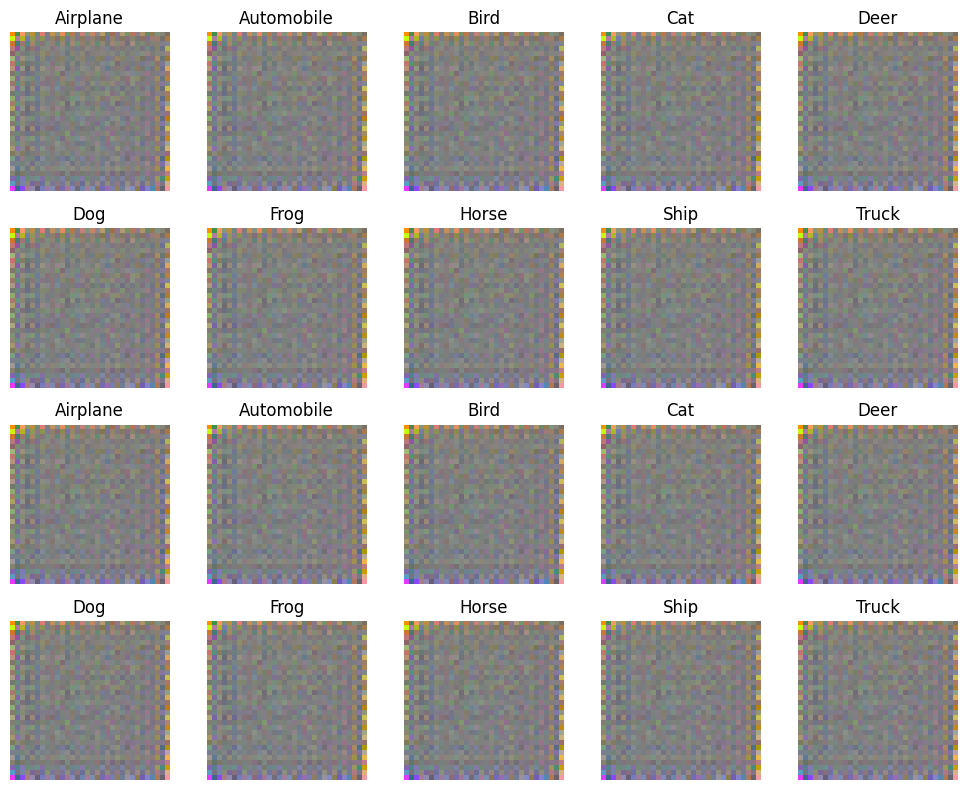

Generator Checkpoint - cGAN/generator-epoch-40.h5
Epoch 41/100
1563/1563 [==============================] - 239s 153ms/step - d_loss: 0.6032 - g_loss: 29.3844
Epoch 42/100
1563/1563 [==============================] - 243s 155ms/step - d_loss: 0.6032 - g_loss: 29.4237
Epoch 43/100
1563/1563 [==============================] - 241s 154ms/step - d_loss: 0.6032 - g_loss: 29.4615
Epoch 44/100
1563/1563 [==============================] - 242s 155ms/step - d_loss: 0.6032 - g_loss: 29.4979
Epoch 45/100
1/1 [==============================] - 0s 27ms/step


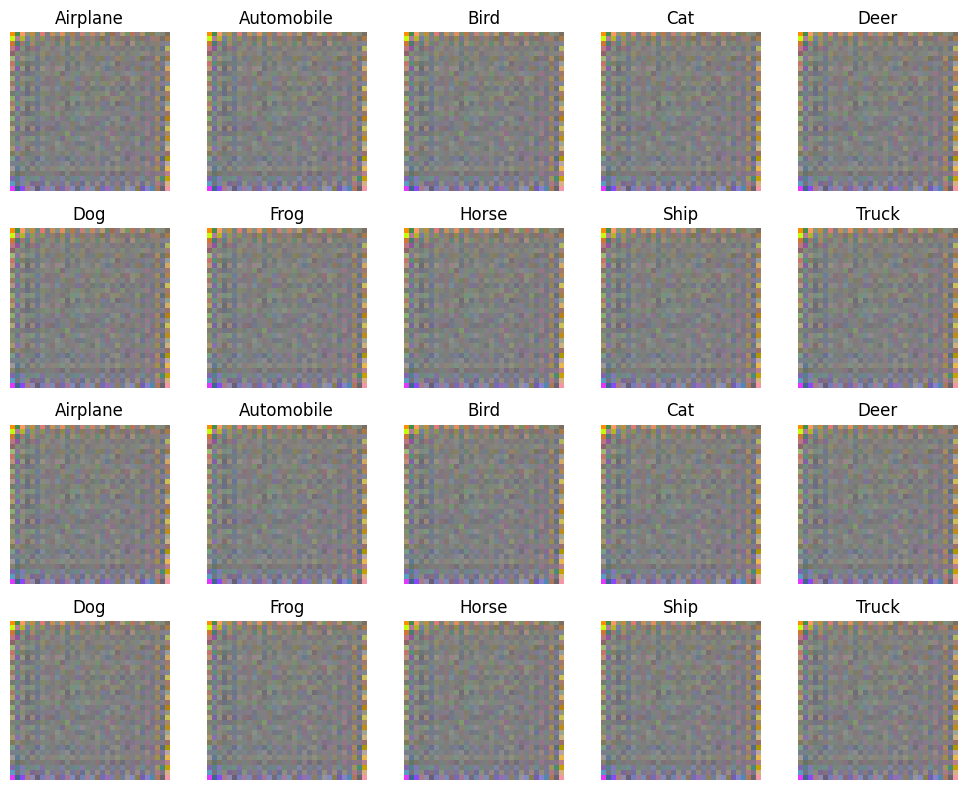

Generator Checkpoint - cGAN/generator-epoch-45.h5
Epoch 46/100
1563/1563 [==============================] - 244s 156ms/step - d_loss: 0.6032 - g_loss: 29.5670
Epoch 47/100
1563/1563 [==============================] - 243s 155ms/step - d_loss: 0.6032 - g_loss: 29.5997
Epoch 48/100
1563/1563 [==============================] - 243s 156ms/step - d_loss: 0.6032 - g_loss: 29.6314
Epoch 49/100
1563/1563 [==============================] - 245s 157ms/step - d_loss: 0.6032 - g_loss: 29.6622
Epoch 50/100
1/1 [==============================] - 0s 33ms/step


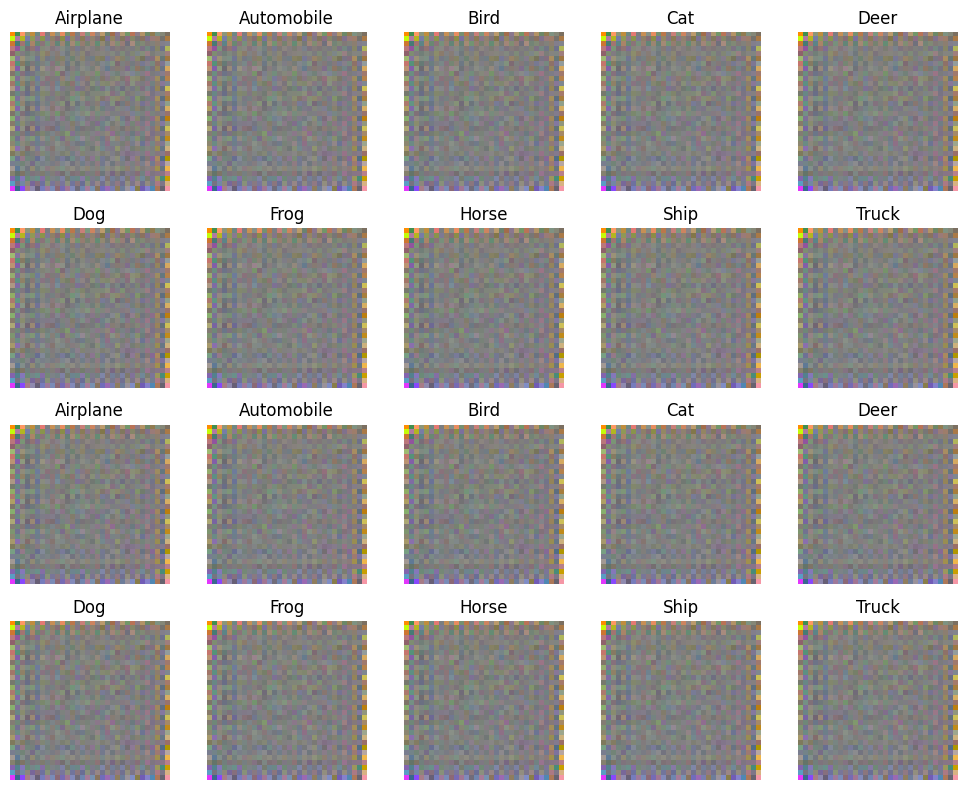

Generator Checkpoint - cGAN/generator-epoch-50.h5
Epoch 51/100
1563/1563 [==============================] - 246s 157ms/step - d_loss: 0.6032 - g_loss: 29.7212
Epoch 52/100
1563/1563 [==============================] - 247s 158ms/step - d_loss: 0.6032 - g_loss: 29.7491
Epoch 53/100
1563/1563 [==============================] - 249s 159ms/step - d_loss: 0.6032 - g_loss: 29.7766
Epoch 54/100
1563/1563 [==============================] - 248s 159ms/step - d_loss: 0.6032 - g_loss: 29.8032
Epoch 55/100
1/1 [==============================] - 0s 26ms/step


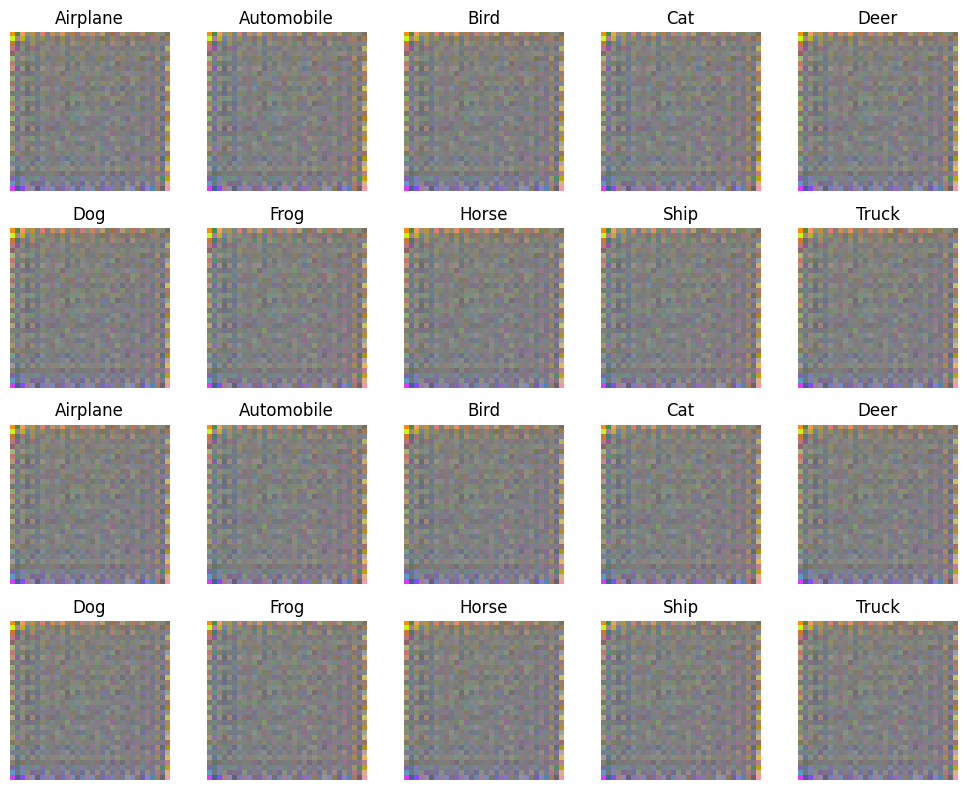

Generator Checkpoint - cGAN/generator-epoch-55.h5
Epoch 56/100
1563/1563 [==============================] - 249s 159ms/step - d_loss: 0.6032 - g_loss: 29.8545
Epoch 57/100
1563/1563 [==============================] - 251s 160ms/step - d_loss: 0.6032 - g_loss: 29.8791
Epoch 58/100
1563/1563 [==============================] - 251s 160ms/step - d_loss: 0.6032 - g_loss: 29.9034
Epoch 59/100
1457/1563 [==========================>...] - ETA: 17s - d_loss: 0.6032 - g_loss: 29.9264

KeyboardInterrupt: 

In [14]:
improve_cond_gan = ConditionalGAN(
    discriminator=create_improve_cGAN_discriminator(image_size=(32, 32, 3)),
    generator=create_improve_cGAN_generator(noise=128),
    noise=128
)

improve_cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    gloss_fn=loss_function,
    dloss_fn=discriminator_loss
)

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(
    64, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

improve_cond_gan_hist = improve_cond_gan.fit(
    dataset, epochs=100, use_multiprocessing=True, workers=16, callbacks=callbacks)

In [ ]:
# story history object into dataframe
improve_cond_gan_hist_df = pd.DataFrame(improve_cond_gan_hist.history)

# using pandas dataframe to plot out learning curve
improve_cond_gan_hist_df.loc[:, ["d_loss", 'g_loss']].plot(
    title=r'Learning Curve of Loss Function CE')

In [ ]:
# Loading Weights for best Generator
best_epoch = 
saved_weights = f'cGAN\generator-epoch-{best_epoch}.h5'
improve_cond_gan.generator.load_weights(saved_weights)

In [ ]:
n = 10000

# generating labels
labels = np.random.randint(low=0, high=10, size=n)
one_hot_labels = to_categorical(labels)

# Generating 1000 Synthetic Images
random_noise = tf.random.normal(shape=(n, 128))

synthetic_images = improve_cond_gan.generator.predict(
    [random_noise, one_hot_labels])
print("Latent Vector Dim: {}\tGenerated Images Dim: {}".format(
    random_noise.shape, synthetic_images.shape))

# Scaling back to [0, 1]
synthetic_images -= -1
synthetic_images /= (1 - (-1))

# Display 25 randomly sampled images
fig = plt.figure(figsize=(10, 10), tight_layout=True)
for i in range(25):
    rand_idx = np.random.randint(0, len(synthetic_images))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(synthetic_images[rand_idx])
    ax.set_title(class_labels[labels[rand_idx]])
    ax.axis('off')
plt.show()

In [ ]:
# inception score functions
# inception score

from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		# subset = subset.astype('float32')
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))
		# pre-process images, scale to [-1,1]
# 		subset = preprocess_input(subset)
		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = mean(sum_kl_d)
		# undo the log
		is_score = exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std

In [ ]:
# find inception score of 10,000 generated synthetic images
is_avg, is_std = calculate_inception_score(synthetic_images)
print('score', is_avg, is_std)